In [1]:
import openslide
from openslide import open_slide
from PIL import Image   # svs images get extracted as "PIL" images
import numpy as np
import matplotlib.pyplot as plt
import os

OSError: libopenslide.so.0: cannot open shared object file: No such file or directory

In [104]:
# Load "svs" file into an object
slide = open_slide('/Users/anirudhgangadhar/Desktop/UHN_Postdoc/Datasets/Liver_biopsy_patient_images/104.svs')

slide_props = slide.properties
print(slide_props)

print('Vendor is: ', slide_props['openslide.vendor'])
print('Pixel size of X in um is: ', slide_props['openslide.mpp-x'])
print('Pixel size of Y in um is: ', slide_props['openslide.mpp-y'])

<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': '10.182.26.185', 'aperio.Date': '03/03/23', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '45', 'aperio.Filename': 'UHN-4131.Slide2', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '354037', 'aperio.Left': '26.132645', 'aperio.LineAreaXOffset': '0.002532', 'aperio.LineAreaYOffset': '0.007483', 'aperio.LineCameraSkew': '0.001300', 'aperio.MPP': '0.2526', 'aperio.OriginalHeight': '62461', 'aperio.OriginalWidth': '60960', 'aperio.Parmset': 'No Decode Barcode', 'aperio.ScanScope ID': 'SS7278', 'aperio.SessonMode': 'NR', 'aperio.StripeWidth': '2032', 'aperio.Time': '10:31:01', 'aperio.Time Zone': 'GMT-05:00', 'aperio.Title': 'Research Project', 'aperio.Top': '19.645500', 'aperio.User': '00000000-0000-0000-0000-000000000000', 'openslide.comment': 'Aperio Image Library v12.0.15 \r\n60960x62461 [0,100 59759x62361] (240x240) JPEG/RGB Q=70|AppMag = 40|Str

In [105]:
# Objective used to capture image
objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print('The objective power is: ', objective)

The objective power is:  40.0


In [106]:
# get slide dimensions for level-0: max. resolution level
slide_dims = slide.dimensions
print('Slide dimensions: ', slide_dims)

Slide dimensions:  (59759, 62361)


In [107]:
# Get a thumbnail (resized version) of image and visualize
slide_thumb_5k = slide.get_thumbnail((5000, 5000))
slide_thumb_5k.show()

type(slide_thumb_5k)

PIL.Image.Image

numpy.ndarray

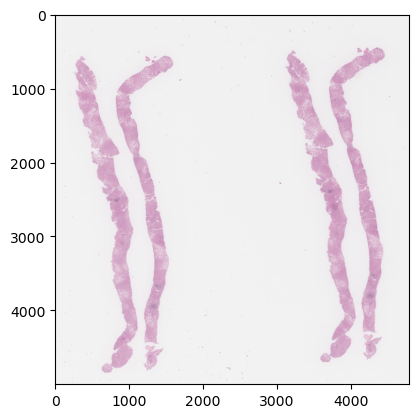

In [108]:
# Convert thumbnail to NumPy array
slide_thumb_5k_np = np.array(slide_thumb_5k)
plt.figure()
plt.imshow(slide_thumb_5k_np);

type(slide_thumb_5k_np)

In [109]:
# Get slide dimensions at each level
# WSIs store information hierarchially
dims = slide.level_dimensions

num_levels = len(dims)
print(f'There are {num_levels} strings in this WSI')
print('Dimensions of various levels are: ', dims)

There are 4 strings in this WSI
Dimensions of various levels are:  ((59759, 62361), (14939, 15590), (3734, 3897), (1867, 1948))


In [110]:
# Downsampling factor
factors = slide.level_downsamples
print('Each level is downsampled by an amount of: ', factors)

Each level is downsampled by an amount of:  (1.0, 4.000132480168121, 16.003163304309318, 32.0104339775788)


numpy.ndarray

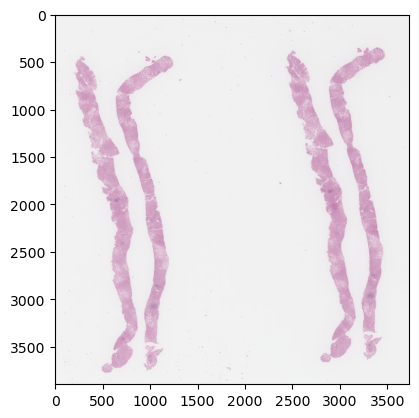

In [111]:
# Copy image from a level
level3_dim = dims[2]
#Give pixel coordinates (top left pixel in the original large image)
#Also give the level number (for level 3 we are providing a value of 2)
#Size of your output image
#Remember that the output would be a RGBA image (Not, RGB)
level3_img = slide.read_region((0,0), 2, level3_dim) #Pillow object, mode=RGBA

#Convert the image to RGB
level3_img_RGB = level3_img.convert('RGB')
# level3_img_RGB.show();

#Convert the image into numpy array for processing
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np);

type(level3_img_np)

In [112]:
# Return the best level for displaying the given downsample
# If we choose the downsampling factor, this tells us what level we should be looking at
SCALE_FACTOR = 32
best_level = slide.get_best_level_for_downsample(SCALE_FACTOR)
#Here it returns the best level to be 2 (third level)
#If you change the scale factor to 2, it will suggest the best level to be 0 (our 1st level)
#################################

best_level

2

In [115]:
#Generating tiles for deep learning training or other processing purposes
#We can use read_region function and slide over the large image to extract tiles
#but an easier approach would be to use DeepZoom based generator.
# https://openslide.org/api/python/

from openslide.deepzoom import DeepZoomGenerator

#Generate object for tiles using the DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
#Here, we have divided our svs into tiles of size 256 with no overlap. 

#The tiles object also contains data at many levels
#Does not need to match slide levels
#To check the number of levels
print("The number of levels in the tiles object are: ", tiles.level_count)

print('')
print("The dimensions of data in each level are: ", tiles.level_dimensions)

#Total number of tiles in the tiles object
print('')
print("Total number of tiles = : ", tiles.tile_count)

#How many tiles at a specific level?
level_num = 11   # this would be the 12th tile
print('')
print("Tile shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], " total tiles in this level")

#Dimensions of the tile (tile size) for a specific tile from a specific layer
tile_dims = tiles.get_tile_dimensions(11, (3,4)) #Provide deep zoom level and address (column, row)

#Tile count at the highest resolution level (level 16 in our tiles)
tile_count_in_large_image = tiles.level_tiles[16] #234 x 244 (59759/256 = 234 with no overlap pixels)
print('')
print('Tile shape at last level: ', tile_count_in_large_image)

#Check tile size for some random tile
tile_dims = tiles.get_tile_dimensions(16, (176,140))
print('')
print('Dimensions of randomly selected tile: ', tile_dims)

#Last tiles may not have full 256x256 dimensions as our large image is not exactly divisible by 256
tile_dims = tiles.get_tile_dimensions(16, (tile_count_in_large_image[0]-1, 
                                           tile_count_in_large_image[1]-1))
print('Dimensions of last tile: ', tile_dims)


single_tile = tiles.get_tile(16, (122, 123)) #Provide deep zoom level and address (column, row)
single_tile_RGB = single_tile.convert('RGB')
# single_tile.show()

###### Saving each tile to local directory
level = 12
cols, rows = tiles.level_tiles[level]   # cols is "0", rows is "1"

tile_dir = "/Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Saved tiles/Original tiles/"
for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(level, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".tiff", temp_tile_np)

The number of levels in the tiles object are:  17

The dimensions of data in each level are:  ((1, 1), (2, 2), (4, 4), (8, 8), (15, 16), (30, 31), (59, 61), (117, 122), (234, 244), (467, 488), (934, 975), (1868, 1949), (3735, 3898), (7470, 7796), (14940, 15591), (29880, 31181), (59759, 62361))

Total number of tiles = :  76232

Tile shape at level  11  is:  (8, 8)
This means there are  64  total tiles in this level

Tile shape at last level:  (234, 244)

Dimensions of randomly selected tile:  (256, 256)
Dimensions of last tile:  (111, 153)
Now saving tile with title:  /Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Saved tiles/Original tiles/0_0
Now saving tile with title:  /Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Saved tiles/Original tiles/1_0
Now saving tile with title:  /Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Saved tiles/Original tiles/2_0
Now saving tile with title:  /Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/S